In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import joblib
import uuid


In [2]:
uniqueid = uuid.uuid4().int & (1 << 64)-1


In [3]:
use_pre_trained_embeds = False

In [4]:
dataset_dir = "imdb"
model_dir = "models"
visuals_dir = "visuals"

# load a preprocessed dataframe see: (https://github.com/3nws/twitter-text-classification/blob/main/notebooks/process_dataframes.ipynb)
df = joblib.load("../dataframes/df_imdb.pkl")

In [5]:
df.shape

(49582, 2)

In [6]:
df.head()

,review,sentiment
0,one review mention watch 1 oz episod youll hoo...,1
1,wonder littl product br br film techniqu veri ...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic famili littl boy jake think zombi closet...,0
4,petter mattei love time money visual stun film...,1


C:\Users\Enes\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

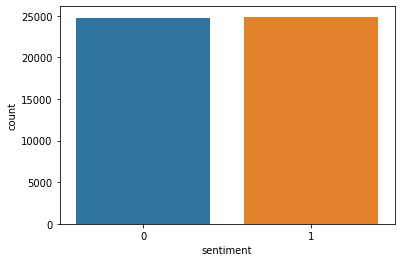

In [7]:

import seaborn as sns

sns.countplot(df.sentiment)


In [8]:
from collections import Counter

# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count


counter = counter_word(df.review)

In [9]:
len(counter)

143417

In [10]:
counter

Counter({'one': 52900,
         'review': 4159,
         'mention': 2966,
         'watch': 27016,
         '1': 2503,
         'oz': 261,
         'episod': 4789,
         'youll': 2603,
         'hook': 571,
         'right': 6744,
         'exact': 2332,
         'happen': 6883,
         'mebr': 449,
         'br': 112957,
         'first': 17171,
         'thing': 15975,
         'struck': 266,
         'brutal': 914,
         'unflinch': 39,
         'scene': 20554,
         'violenc': 1988,
         'set': 7486,
         'word': 3531,
         'go': 17594,
         'trust': 706,
         'show': 19169,
         'faint': 134,
         'heart': 2613,
         'timid': 55,
         'pull': 1831,
         'punch': 524,
         'regard': 934,
         'drug': 1629,
         'sex': 3193,
         'hardcor': 250,
         'classic': 4110,
         'use': 9979,
         'wordbr': 15,
         'call': 5393,
         'nicknam': 83,
         'given': 3521,
         'oswald': 31,
         '

In [11]:
counter.most_common(5)

[('br', 112957),
 ('movi', 98208),
 ('film', 91427),
 ('one', 52900),
 ('like', 43621)]

In [12]:
num_unique_words = len(counter)

In [13]:
# Split dataset into training and validation set
train_size = int(df.shape[0] * 0.8)

train_df = df[:train_size]
val_df = df[train_size:]

# split text and labels
train_sentences = train_df.review.to_numpy()
train_labels = train_df.sentiment.to_numpy()
val_sentences = val_df.review.to_numpy()
val_labels = val_df.sentiment.to_numpy()

In [14]:
train_sentences.shape, val_sentences.shape

((39665,), (9917,))

In [15]:
# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

# vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences) # fit only to training

In [16]:
# each word has unique index
word_index = tokenizer.word_index

In [17]:
word_index

{'br': 1,
 'movi': 2,
 'film': 3,
 'one': 4,
 'like': 5,
 'time': 6,
 'good': 7,
 'make': 8,
 'get': 9,
 'veri': 10,
 'see': 11,
 'charact': 12,
 'watch': 13,
 'even': 14,
 'stori': 15,
 'would': 16,
 'onli': 17,
 'realli': 18,
 'scene': 19,
 'well': 20,
 'look': 21,
 'show': 22,
 'much': 23,
 'bad': 24,
 'great': 25,
 'end': 26,
 'peopl': 27,
 'also': 28,
 'love': 29,
 'go': 30,
 'becaus': 31,
 'think': 32,
 'first': 33,
 'play': 34,
 'act': 35,
 'dont': 36,
 'way': 37,
 'thing': 38,
 'made': 39,
 'could': 40,
 'ani': 41,
 'know': 42,
 'seem': 43,
 'say': 44,
 'mani': 45,
 'plot': 46,
 'work': 47,
 'two': 48,
 'actor': 49,
 'seen': 50,
 'want': 51,
 'take': 52,
 'come': 53,
 'never': 54,
 'tri': 55,
 'best': 56,
 'littl': 57,
 'year': 58,
 'life': 59,
 'ever': 60,
 'doe': 61,
 'give': 62,
 'man': 63,
 'better': 64,
 'still': 65,
 'find': 66,
 'perform': 67,
 'feel': 68,
 'part': 69,
 'whi': 70,
 'use': 71,
 'actual': 72,
 'someth': 73,
 'lot': 74,
 'interest': 75,
 'im': 76,
 'back': 

In [18]:
len_of_vocab = len(word_index)

In [19]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

In [20]:
print(train_sentences[10:15])
print(train_sequences[10:15])

['phil alien one quirki film humour base around odd everyth rather actual punchlinesbr br first veri odd pretti funni movi progress didnt find joke odd funni anymorebr br low budget film never problem pretti interest charact eventu lost interestbr br imagin film would appeal stoner current partakingbr br someth similar better tri brother anoth planet'
 'saw movi 12 came recal scariest scene big bird eat men dangl helpless parachut right air horror horrorbr br young kid go cheesi b film saturday afternoon still tire formula monster type movi usual includ hero beauti woman might daughter professor happi resolut monster die end didnt care much romant angl 12 year old predict plot love unintent humorbr br year later saw psycho came love star janet leigh bump earli film sat took notic point sinc screenwrit make stori make scari possibl wellworn formula rule'
 'im big fan boll work mani enjoy movi postal mayb im onli one boll appar bought right use far cri long ago even befor game even finsi

In [21]:
# Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Max number of words in a sequence
# max_length = max([len(text) for text in train_sequences])
max_length = 128
max_length

128

In [22]:

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")
train_padded.shape, val_padded.shape

((39665, 128), (9917, 128))

In [23]:
train_padded[10]

array([ 3522,   675,     4,  2149,     3,  1089,   355,   118,   713,
         208,   185,    72, 32081,     1,    33,    10,   713,   113,
          85,     2,  1421,    82,    66,   353,   713,    85,  9268,
           1,   412,   340,     3,    54,   228,   113,    75,    12,
         725,   382,  8299,     1,   386,     3,    16,   810,  6247,
        1256, 51407,     1,    73,   517,    64,    55,   381,    84,
        1123,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [24]:
print(train_sentences[10])
print(train_sequences[10])
print(train_padded[10])

phil alien one quirki film humour base around odd everyth rather actual punchlinesbr br first veri odd pretti funni movi progress didnt find joke odd funni anymorebr br low budget film never problem pretti interest charact eventu lost interestbr br imagin film would appeal stoner current partakingbr br someth similar better tri brother anoth planet
[3522, 675, 4, 2149, 3, 1089, 355, 118, 713, 208, 185, 72, 32081, 1, 33, 10, 713, 113, 85, 2, 1421, 82, 66, 353, 713, 85, 9268, 1, 412, 340, 3, 54, 228, 113, 75, 12, 725, 382, 8299, 1, 386, 3, 16, 810, 6247, 1256, 51407, 1, 73, 517, 64, 55, 381, 84, 1123]
[ 3522   675     4  2149     3  1089   355   118   713   208   185    72
 32081     1    33    10   713   113    85     2  1421    82    66   353
   713    85  9268     1   412   340     3    54   228   113    75    12
   725   382  8299     1   386     3    16   810  6247  1256 51407     1
    73   517    64    55   381    84  1123     0     0     0     0     0
     0     0     0     0    

In [25]:
# Check reversing the indices

# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [26]:
reverse_word_index

{1: 'br',
 2: 'movi',
 3: 'film',
 4: 'one',
 5: 'like',
 6: 'time',
 7: 'good',
 8: 'make',
 9: 'get',
 10: 'veri',
 11: 'see',
 12: 'charact',
 13: 'watch',
 14: 'even',
 15: 'stori',
 16: 'would',
 17: 'onli',
 18: 'realli',
 19: 'scene',
 20: 'well',
 21: 'look',
 22: 'show',
 23: 'much',
 24: 'bad',
 25: 'great',
 26: 'end',
 27: 'peopl',
 28: 'also',
 29: 'love',
 30: 'go',
 31: 'becaus',
 32: 'think',
 33: 'first',
 34: 'play',
 35: 'act',
 36: 'dont',
 37: 'way',
 38: 'thing',
 39: 'made',
 40: 'could',
 41: 'ani',
 42: 'know',
 43: 'seem',
 44: 'say',
 45: 'mani',
 46: 'plot',
 47: 'work',
 48: 'two',
 49: 'actor',
 50: 'seen',
 51: 'want',
 52: 'take',
 53: 'come',
 54: 'never',
 55: 'tri',
 56: 'best',
 57: 'littl',
 58: 'year',
 59: 'life',
 60: 'ever',
 61: 'doe',
 62: 'give',
 63: 'man',
 64: 'better',
 65: 'still',
 66: 'find',
 67: 'perform',
 68: 'feel',
 69: 'part',
 70: 'whi',
 71: 'use',
 72: 'actual',
 73: 'someth',
 74: 'lot',
 75: 'interest',
 76: 'im',
 77: 'bac

In [27]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [28]:
decoded_text = decode(train_sequences[10])

print(train_sequences[10])
print(decoded_text)

[3522, 675, 4, 2149, 3, 1089, 355, 118, 713, 208, 185, 72, 32081, 1, 33, 10, 713, 113, 85, 2, 1421, 82, 66, 353, 713, 85, 9268, 1, 412, 340, 3, 54, 228, 113, 75, 12, 725, 382, 8299, 1, 386, 3, 16, 810, 6247, 1256, 51407, 1, 73, 517, 64, 55, 381, 84, 1123]
phil alien one quirki film humour base around odd everyth rather actual punchlinesbr br first veri odd pretti funni movi progress didnt find joke odd funni anymorebr br low budget film never problem pretti interest charact eventu lost interestbr br imagin film would appeal stoner current partakingbr br someth similar better tri brother anoth planet


In [29]:
embedding_dim = 32

if use_pre_trained_embeds:
    embeddings_dictionary = dict()
    glove_file = open('../embeds/glove.6B.300d.txt', 'rb')

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

    glove_file.close()

    embeddings_matrix = np.zeros((num_unique_words, embedding_dim))
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embeddings_matrix[index] = embedding_vector


In [30]:
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy


In [31]:
# 'softmax' activation function returns a probability distribution
# Binary for 0-1, Categorical for 2 or more classes, SparseCategorical for when labels are integers
# Dropout is used to prevent overfitting by randomly setting inputs to 0 at a low rate
# For stacked LSTMs set return_sequences to True except for the last one
# trainable parameter in Embedding layer should still be set to True when using already trained weights (it is by default anyway)

# 0
def Glove_Double_Bi_LSTM_w_Loss_Sparse_Cat():
    model = Sequential()
    model.add(Embedding(num_unique_words, embedding_dim,
                        input_length=max_length, name="embeddinglayer", weights=[embeddings_matrix], trainable=True))
    model.add(Bidirectional(LSTM(64, dropout=0.3, return_sequences=True)))
    model.add(Bidirectional(LSTM(64, dropout=0.3)))
    model.add(Dense(2, activation="softmax"))
    loss = SparseCategoricalCrossentropy(from_logits=False)
    optim = Adam(lr=0.001)
    metrics = [
        "accuracy",
        "sparse_categorical_accuracy",
    ]
    model.compile(loss=loss, optimizer=optim, metrics=metrics)
    return model

# 1
def LSTM_w_Loss_Binary():
    model = Sequential()
    model.add(Embedding(num_unique_words, embedding_dim,
                               input_length=max_length, name="embeddinglayer"))
    model.add(LSTM(64, dropout=0.1))
    model.add(Dense(1, activation="sigmoid"))
    loss = BinaryCrossentropy(from_logits=False)
    optim = Adam(lr=0.001)
    metrics = [
        "accuracy",
        "binary_accuracy",
    ]
    model.compile(loss=loss, optimizer=optim, metrics=metrics)
    return model
    
# 2
def LSTM_w_Loss_Sparse_Cat():
    model = Sequential()
    model.add(Embedding(num_unique_words, embedding_dim,
                               input_length=max_length, name="embeddinglayer"))
    model.add(LSTM(64, dropout=0.1))
    model.add(Dense(2, activation="softmax"))
    loss = SparseCategoricalCrossentropy(from_logits=False)
    optim = Adam(lr=0.001)
    metrics = [
        "accuracy",
        "sparse_categorical_accuracy",
    ]
    model.compile(loss=loss, optimizer=optim, metrics=metrics)
    return model

# 3
def Bi_LSTM_w_Loss_Sparse_Cat():
    model = Sequential()
    model.add(Embedding(num_unique_words, embedding_dim,
                               input_length=max_length, name="embeddinglayer"))
    model.add(Bidirectional(LSTM(64, dropout=0.2)))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(2, activation="softmax"))
    loss = SparseCategoricalCrossentropy(from_logits=False)
    optim = Adam(lr=0.001)
    metrics = [
        "accuracy",
        # "sparse_categorical_accuracy",
    ]
    model.compile(loss=loss, optimizer=optim, metrics=metrics)
    return model

# 4
def Double_Bi_LSTM_w_Loss_Sparse_Cat():
    model = Sequential()
    model.add(Embedding(num_unique_words, embedding_dim,
                        input_length=max_length, name="embeddinglayer"))
    model.add(Bidirectional(LSTM(64, dropout=0.3, return_sequences=True)))
    model.add(Bidirectional(LSTM(64, dropout=0.3)))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(2, activation="softmax"))
    loss = SparseCategoricalCrossentropy(from_logits=False)
    optim = Adam(lr=0.001)
    metrics = [
        "accuracy",
        "sparse_categorical_accuracy",
    ]
    model.compile(loss=loss, optimizer=optim, metrics=metrics)
    return model

In [32]:
models = [
    Glove_Double_Bi_LSTM_w_Loss_Sparse_Cat,
    LSTM_w_Loss_Binary,
    LSTM_w_Loss_Sparse_Cat,
    Bi_LSTM_w_Loss_Sparse_Cat,
    Double_Bi_LSTM_w_Loss_Sparse_Cat,
]

model_to_use = -1

model_idx = 0 if use_pre_trained_embeds else model_to_use


In [33]:


model = models[model_idx]()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddinglayer (Embedding)  (None, 128, 32)           4589344   
                                                                 
 bidirectional (Bidirectiona  (None, 128, 128)         49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 4,742,018
Trainable params: 4,742,018
Non-

C:\Users\Enes\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [34]:
train_padded.shape

(39665, 128)

In [35]:
history = model.fit(train_padded, train_labels, epochs=4, validation_data=(val_padded, val_labels), verbose=1)

Epoch 1/4
1240/1240 [==============================] - 69s 48ms/step - loss: 0.3739 - accuracy: 0.8336 - sparse_categorical_accuracy: 0.8336 - val_loss: 0.2929 - val_accuracy: 0.8818 - val_sparse_categorical_accuracy: 0.8818
Epoch 2/4
1240/1240 [==============================] - 61s 50ms/step - loss: 0.2010 - accuracy: 0.9260 - sparse_categorical_accuracy: 0.9260 - val_loss: 0.3003 - val_accuracy: 0.8837 - val_sparse_categorical_accuracy: 0.8837
Epoch 3/4
1240/1240 [==============================] - 58s 47ms/step - loss: 0.1235 - accuracy: 0.9560 - sparse_categorical_accuracy: 0.9560 - val_loss: 0.3347 - val_accuracy: 0.8717 - val_sparse_categorical_accuracy: 0.8717
Epoch 4/4
1240/1240 [==============================] - 57s 46ms/step - loss: 0.0788 - accuracy: 0.9724 - sparse_categorical_accuracy: 0.9724 - val_loss: 0.3802 - val_accuracy: 0.8705 - val_sparse_categorical_accuracy: 0.8705


In [40]:

val_loss, val_acc, * \
    catch_excess = model.evaluate(val_padded, val_labels)
val_loss, val_acc, catch_excess


310/310 [==============================] - 7s 22ms/step - loss: 0.3802 - accuracy: 0.8705 - sparse_categorical_accuracy: 0.8705


(0.3801986277103424, 0.8705253601074219, [0.8705253601074219])

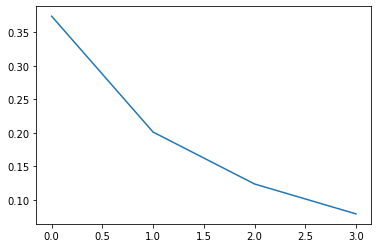

In [61]:
model_name = models[model_idx].__name__
model_export = f"NN_model_{model_name}_{uniqueid}_{val_acc}"
vis_dir = f'../{visuals_dir}/{model_export}'
model_save_dir = f'../{model_dir}/{model_export}'
# plotting training graph

plt.plot(history.history['loss'])
plt.savefig(f'{model_save_dir}.png')


In [42]:
predictions = model.predict(train_padded)


In [43]:

predictions.shape


(39665, 2)

In [44]:
predictions

array([[0.00899707, 0.9910029 ],
       [0.00319165, 0.99680835],
       [0.00407161, 0.99592835],
       ...,
       [0.99278146, 0.00721853],
       [0.06517637, 0.93482363],
       [0.9159665 , 0.0840335 ]], dtype=float32)

In [45]:
val_predictions = model.predict(val_padded)


In [46]:
print(val_sentences[42])
print(val_labels[42])
print(val_predictions[42])


im surpris mani peopl give move less 7 starsbr br dont understand moviebr br stori grow difficult situationbr br crazi grandmoth realli want best grandchildrenbr br good reason whi mani critic like moviebr br reason becaus understand moviebr br feel sorri low score given peoplebr br wish could write brief summari movi imdb requir write 10 linesbr br frank dont anyth els say
1
[0.7256093  0.27439067]


In [ ]:
# Only for BinaryCrossentropy
# predictions = [1 if p > 0.5 else 0 for p in predictions]
# predictions

(0.0, 0.3952694460749626)

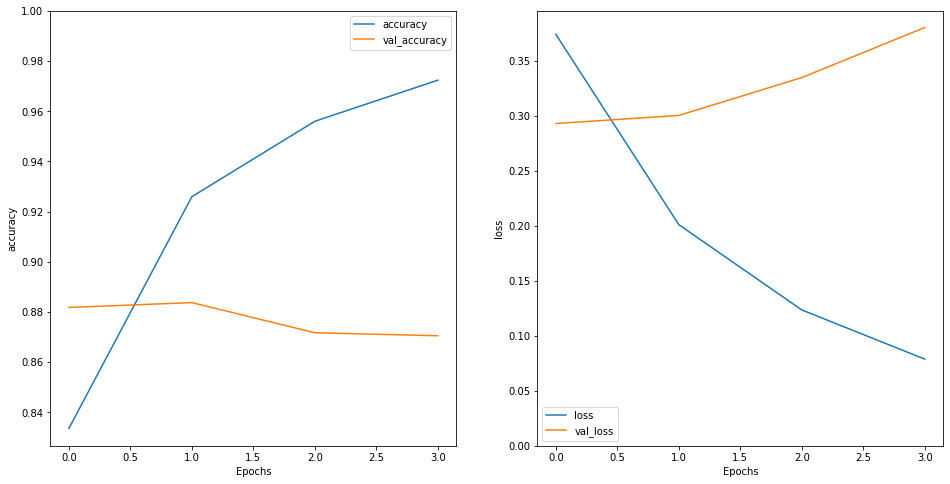

In [47]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


In [62]:
model.save(model_save_dir)


INFO:tensorflow:Assets written to: ../models/NN_model_Double_Bi_LSTM_w_Loss_Sparse_Cat_13175934382125418181_0.8705253601074219\assets


INFO:tensorflow:Assets written to: ../models/NN_model_Double_Bi_LSTM_w_Loss_Sparse_Cat_13175934382125418181_0.8705253601074219\assets


In [63]:
loaded_model = load_model(model_save_dir)


In [64]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddinglayer (Embedding)  (None, 128, 32)           4589344   
                                                                 
 bidirectional (Bidirectiona  (None, 128, 128)         49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 4,742,018
Trainable params: 4,742,018
Non-

In [ ]:
# For debugging purposes


# model = keras.Model(inputs=model.input,
#                     outputs=[model.get_layer("embeddingL").output])

# feature = model.predict(val_padded)

# feature, feature.shape